# Predicting the Sentiment of Movie Reviews
Ben Sinko

## Imports

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_svmlight_file
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeClassifier, plot_tree
import time
from IPython.display import Image

# Introduction

***TODO: insert summary of project goals/questions being answered***

# Data

For this project, we are using the *Large Movie Review Dataset* from the 2011 publication, *Learning Word Vectors for Sentiment Analysis*. The dataset contains the text from 50,000 movie reviews labeled 0 through 10, with 25,000 designated for training and the other 25,000 for testing. Also included is a tokenized bag of words (BOW) that contains a count of the number of times a given word appears in a review. The inclusion of this BOW removed the need for us to process the text ourselves, and can be directly used as the input for our various machine learning models.

#### Bag of Words Reference

Here, we read in the "imdb.vocab" file, which acts as a reference for the bag of words described above. The bag of words contains a bunch of key-value pairs, in which the key is the index of the word in this reference array, and the value is the number of times that word that appears in the reviews. For example, if the first element in a sample of input data is 12, that means the word 'the' (the first element in the reference) appears 12 times in that review.

In [4]:
# bow_reference contains the list of words that correspond to the bag of words representation
bow_reference = pd.read_table('aclImdb/imdb.vocab', header = None)[0].values

# drop the last four words to keep in line with test data
bow_reference = bow_reference[:-4]
print(bow_reference)

['the' 'and' 'a' ... 'profanity-laced' 'sarah-michelle' 'copywrite']


#### Training Data

Next, we import the training bag of words which is stored in a `.feat` file. 

In [5]:
# load in and format the training and testing data

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
# X is a Sparse Matrix that contains the word counts for each review
# y is a NumPy array that contains the review score 
X, y = load_svmlight_file('aclImdb/train/labeledBow.feat')

*Note: We dropped the final 4 columns of the training data to ensure that the data format was identical for both the training and testing sets. These four columns represented words that occurred in only one sample of the training set, so this should have no noticable effect on the accuracy.*

In [6]:
# the X.toarray() converts the sparse matrix to a 2D NumPy array, which is then converted to a Pandas DF
Xdata = pd.DataFrame(X.toarray())
Xdata = Xdata.drop(columns=[89523, 89524, 89525, 89526])

print("Samples:", Xdata.shape[0])
print("Unique Words:", Xdata.shape[1])

Samples: 25000
Unique Words: 89523


Here, we convert the all review scores 0-4 to negative (0) and 5-10 to positive (1). Since we are only using simple word counts to classify the data, it seemed very unrealistic that the machine learning models would be able to accurately predict the score of a particular review. By changing our classification to only positive or negative, we hope to increase the chance of creating an accurate prediction model.

In [7]:
# changes all review scores 0-4 to negative (0) and 5-10 to positive(1)
ydata = pd.DataFrame(y)
ydata = ydata.replace({0:0,1:0,2:0,3:0,4:0,5:1,6:1,7:1,8:1,9:1,10:1})

#### Testing Data

The process of importing the testing data is exactly the same as the training data.

In [8]:
X, y = load_svmlight_file('aclImdb/test/labeledBow.feat')

In [9]:
Xtest = pd.DataFrame(X.toarray())

print("Samples:", Xtest.shape[0])
print("Unique Words:", Xtest.shape[1])

Samples: 25000
Unique Words: 89523


In [10]:
ytest = pd.DataFrame(y)
ytest = ytest.replace({0:0,1:0,2:0,3:0,4:0,5:1,6:1,7:1,8:1,9:1,10:1})

#### Data Format

Below is a visual representation of the data format. Every row represents a unique sample, and each column represents how many time the corresponding word occurred in that sample. For example, the 0th element of row 0 is 9.0, meaning that the first word in the bow_reference ('the') appears 9 times in that sample.

In [11]:
# prints first four rows of Xdata
Xdata.head(4)

,0,1,2,3,4,5,6,7,8,9,...,89513,89514,89515,89516,89517,89518,89519,89520,89521,89522
0,9.0,1.0,4.0,4.0,6.0,4.0,2.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,4.0,2.0,2.0,0.0,4.0,1.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,4.0,7.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,2.0,2.0,0.0,3.0,2.0,4.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training and Testing

## MLPClassifier

The MLPClassifier is a supervised machine learning function that uses a Multilevel Perceptron (MLP) model to make binary classifications of input data. MLP models work by passing data through a series of hidden, weighted "neuron" layers which are then used as the input for an activation function that classifies the data. This is very similar to the Perceptron model, with the key difference being the addition of hidden neuron layers. A visual representation of the MLP model can be found below.

<img src="https://t1.daumcdn.net/cfile/tistory/2115D1495530A29336" width=600px>
<p style="text-align: right;">MLP Visualization is from: https://goodtogreate.tistory.com/262 </p>

In order to optimize the accuracy of the MLPClassifier, various inputs for the model parameters of `hidden_layer_sizes`, `activation`, and `solver` were placed into a Grid Search. `hidden_layer_sizes` determines the number of hidden layers present and the number of neurons in each layer, `activation` determines which activation function is being used, and `solver` determines which function is being used to determine the weight of each neuron. The code for determining the optimal combination of parameters, as well as the output, can be found in the cell below. It is placed in a markdown cell, as the code took just over 12 hours to run. 

#### Input
```
# the grid of parameters being searched through to find the best combination
param_grid = {'hidden_layer_sizes': [(20,), (20, 20,), (20, 20, 20), (50,), (50, 50,), (50, 50, 50)],
              'activation': ['relu', 'tanh'],
              'solver': ['lbfgs','adam']}

# creates a GridSearch object that is then fitted to determine the best combination
mlp = GridSearchCV(MLPClassifier(random_state = 22), param_grid)

# fits all combinations and returns the model with the best combination
mlp = mlp.fit(Xdata, ydata.values.reshape(1,-1)[0])

print("Best estimator found by grid search:")
print(mlp.best_estimator_)
print("Best parameters found by grid search:")
print(mlp.best_params_)
```

#### Output
```
Best estimator found by grid search:
MLPClassifier(activation = 'relu', hidden_layer_sizes = (50, 50), solver = 'adam')
Best parameters found by grid search:
{'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}
```

In [17]:
# trains the model with the best parameters found from the grid search above
start = time.time()
best_mlp = MLPClassifier(activation = 'relu', hidden_layer_sizes = (50, 50), solver = 'adam', random_state = 22)
best_mlp.fit(Xdata, ydata[0].values)
end = time.time()
print("Runtime: ", end - start)

Runtime:  415.3508803844452


In [18]:
# generates predictions for every sample of the test data
start = time.time()
model_test = best_mlp.predict(Xtest)
end = time.time()
print("Runtime: ", end - start)

Runtime:  2.329716682434082


In [19]:
# prints a classification report and confusion matrix to analyze results
print(classification_report(ytest, model_test))
print(confusion_matrix(ytest, model_test))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     12500
         1.0       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

[[10889  1611]
 [ 1935 10565]]


#### Pros
- High accuracy, with a fairly even recall and precision on errors
- Fast prediction time -- once model is trained, predictions take seconds

#### Cons
- Long fit time -- back propogation through multiple layers takes time
- Black box -- Not at all clear how decisions are being made in the model

#### Sources
- https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
- https://goodtogreate.tistory.com/262

## Perceptron

Perceptron is a single layer neural network that takes in all of the input variables and then multiplies them by their weights, it then adds all these values together and gets a value between 0 and 1 or -1 and 1 depending on what you want to use as your labels.

The two parameters that I choose to modify were alpha and tol. Alpha is the constant that multiplies the regularization term if regularization is used. And tol is The stopping criterion. If it is not None, the iterations will stop when (loss > previous_loss - tol).

<img src="https://www.simplilearn.com/ice9/free_resources_article_thumb/general-diagram-of-perceptron-for-supervised-learning.jpg" width=600px>
<p style="text-align: right;">This image is from: https://www.simplilearn.com/what-is-perceptron-tutorial </p>

In [9]:
#Initalize a perceptron object with the default parameters
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(Xdata,ydata.values.ravel())

Perceptron()

In [10]:
#Use the modle to predict values
pred_labels = clf.predict(Xtest)

In [11]:
#Printing the results to check how good the model did
print(classification_report(ytest, pred_labels))
print(confusion_matrix(ytest, pred_labels))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.85     12500
         1.0       0.88      0.81      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

[[11078  1422]
 [ 2336 10164]]


In [ ]:
#running this Grid Search worked fine but only gave the default parameters as the best ones
param_grid = {'tol': [1e-3, 5e-3],
              'alpha': [0.0001, 0.0005]}

In [ ]:
#Grid Search crashed with this many parameters
param_grid = {'tol': [1e-3, 5e-3, 1e-4, 5e-4, 1e-5],
              'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(Perceptron(), param_grid)
clf = clf.fit(Xtraindata,ytrain.values.ravel())


print("Best parameters found by grid search:")
print(clf.best_params_)

In the grid search that did not crash, which only had the two options for each parameter, the grid search returned that the best parameters were the default parameters, with the default parameters the accuracy of the model was 85% which is not too bad for the simplest neural network model.

For this model the pro is also the con because it is such a simple model, depending on the situation you may want a simple model but there are more complex models that could give you better results. 

## Stochastic Gradient Descent

In [ ]:
model = linear_model.SGDClassifier(random_state=0)
fit = model.fit(X_train,y_train.values.ravel())

In [ ]:
predict_vectors = X_test
true_labels = y_test

pred_labels = fit.predict(predict_vectors)

print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels))

Output:
```
precision    recall  f1-score   support

         0.0       0.81      0.91      0.86     12500
         1.0       0.90      0.78      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

[[11424  1076]
 [ 2716  9784]]
```

In [ ]:
start = time.time()

tmp_vectors = X_test
tmp_labels = y_test

print("Fitting the classifier to the training set")
param_grid = {'tol': [1e-4, 1e-3, 0.01, 0.1],
              'alpha': [0.00001, 0.0001, 0.001, 0.01],
              'learning_rate': ['constant','optimal']}

clf = GridSearchCV(SGDClassifier(random_state=1,eta0=0.1), param_grid)
clf = clf.fit(tmp_vectors, tmp_labels.values.ravel())
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)

end = time.time()
print("Runtime",end - start)

#Runtime 11723.690677165985

Output:
```
Fitting the classifier to the training set
Best estimator found by grid search:
SGDClassifier(alpha=0.01, eta0=0.1, random_state=1, tol=0.0001)
Best parameters found by grid search:
{'alpha': 0.01, 'learning_rate': 'optimal', 'tol': 0.0001}
Runtime 11723.690677165985
```

This is model above is using a Stochastic Gradient Descent model which uses a iterative algorithm, that starts from a random point on a function and travels down its slope in steps until it reaches the lowest point of that function.
So it basically first:

1. Finds the slope of the objective function with respect to each parameter/feature. In other words, compute the gradient of the function.
2. Picks a random initial value for the parameters. 
3. Update the gradient function by plugging in the parameter values.
4. Calculate the step sizes for each feature as : step size = gradient * learning rate.
5. Calculate the new parameters as : new params = old params -step size
6. Repeat steps 3 to 5 until gradient is almost 0.

Image below demonstrates this.

<img src="https://www.researchgate.net/profile/Bhaskar-Ghosh/publication/344544069/figure/fig4/AS:944366457729024@1602165917164/Stochastic-Gradient-Descent.ppm" width=600px>
<p style="text-align: right;">This image is from: https://www.researchgate.net/figure/Stochastic-Gradient-Descent_fig4_344544069 </p>

The grid search used the same parameters that is used from the beginning which means that default mode of gradient algorithm was already optimized as it was defaulted to optimized the most. This made the accuracy of the model to be around 85% which is high end of the spectrum of accuracys.

Its pros can contribute to the fact that it is computationally fast and provides faster converging as it causes updates to the parameters more frequently. Disadvantages could be that the frequent updates are computationally expensive in this model which makes the model spend all resources on one sample/training.

Citations/Websites:

https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31

https://www.researchgate.net/figure/Stochastic-Gradient-Descent_fig4_344544069

https://scikit-learn.org/stable/modules/sgd.html#classification

## Decision Tree

A decision tree is a supervised learning model that predicts the class of an input for a set of binary decision rules. Each node in the tree contains one such a rule - for example, if a movie review contains the word 'great' more than 5 times, branch left, otherwise classify as negative. A decision tree is built by chaining these rules together into a branching structure. The leaf nodes of the tree contain the decision of how to classify the input, such as "positive" or "negative".

The parameters tested for this decision tree are `criterion`, `splitter`, `max_depth`, and `min_samples_split`. `criterion` and `splitter` are used to specify how to make training decisions at each node. `max_depth` and `min_samples_split` are used to limit overfitting. A Grid Search was run to determine the combination of parameters that yields the best peformance, the code for which and resulting output are shown below. (Note: this is included as markdown instead of a code block because it took upwards of 10 hours to run.)

```
start = time.time()

param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 100, 1000, 10000],
              'min_samples_split': [2, 10, 100, 1000]}

# make a classifier by searching over a classifier and the parameter grid
tree = GridSearchCV(DecisionTreeClassifier(), param_grid)

# we have a "good" classifier (according to GridSearchCV), how's it look
tree = tree.fit(Xdata, ydata)

print("Best estimator found by grid search:")
print(tree.best_estimator_)
print("Best parameters found by grid search:")
print(tree.best_params_)

end = time.time()
print("Runtime",end - start)
```

<br><br>

Output:

```
Best estimator found by grid search:
DecisionTreeClassifier(criterion='entropy', max_depth=100,
                       min_samples_split=1000, splitter='random')
Best parameters found by grid search:
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 1000, 'splitter': 'random'}
Runtime 46619.721442461014
```

<br><br>

Below, a decision tree is trained using the best parameters selected by the grid search.

In [9]:
start = time.time()

# train the decision tree model on the training data
tree = DecisionTreeClassifier(criterion="entropy", max_depth=100, min_samples_split=1000, splitter="random")
tree.fit(Xdata, ydata)

end = time.time()
print("Runtime",end - start)

Runtime 157.15520572662354


In [10]:
start = time.time()

# use the trained models to predict the values for the test data
pred_labels = tree.predict(Xtest)

end = time.time()
print("Runtime",end - start)

Runtime 3.3699564933776855


In [11]:
# compare the predictions to the actual test labels to evaluate performance
print(confusion_matrix(ytest, pred_labels,))
print(classification_report(ytest, pred_labels))

[[9707 2793]
 [3852 8648]]
              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75     12500
         1.0       0.76      0.69      0.72     12500

    accuracy                           0.73     25000
   macro avg       0.74      0.73      0.73     25000
weighted avg       0.74      0.73      0.73     25000



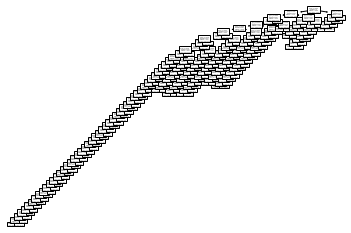

In [15]:
#visualize the decision tree
plot_tree(tree)
print()

pros
- very quick to predict (logarithmic, just have to traverse the tree)
- simple to understand and interpret - can visualize the tree
    - not a black box like neural networks - very clear how decision is being made
    
cons
- overfitting - can create over-complex models that do not generalise to the data well
- lower test performance compared to the other models tested

Sources
- https://scikit-learn.org/stable/modules/tree.html#tree
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Odinary Least Squares with Ridge Regression

#### Overview
Ridge Regression is a way to ensure you do not overfit your training data - essentially, we are desensitizing (normalizing) the model to the training data. A line is fit using the least squares technique, but the coefficients are not estimated by ordinary least squares, but by an estimator called ridge estimator that is biased but has lower variance than the OLS estimator. In other words, by starting with a slightly worse fit, Ridge Regression can provide better long-term predictions with lower variance. 

#### How it works

When Ridge Regression determines values for the parameters of its fit:

__Size__ = y-axis intercept + slope x __Weight__

It minimizes the __sum of the squared residuals + λ x slope^2__


<img src="https://i.stack.imgur.com/s71QZ.png" width=600px>
<p style="text-align: right;">Source: https://stats.stackexchange.com/questions/402889/why-ridge-regression-only-decreases-slope-and-not-increases-it </p>


The red line in the visualization above is Ordinary Least Squares minimized with the sum of the squared residuals, and __the blue line is Ridge Regression minimized with the sum of the squared residuals +  λ x slope^2__. The value for lambda reduces the slope, making the prediction for size less sensitive to weight in this example.

In [12]:
# Initalize object with the default parameters
ols = linear_model.RidgeClassifier() 
ols.fit(Xdata, ydata[0].values)

RidgeClassifier()

In [13]:
# generates predictions for every sample of the test data
start = time.time()
model_test = ols.predict(Xtest)
end = time.time()
print("Runtime: ", end - start)

Runtime:  9.361006736755371


In [22]:
# printing model performance results
print(classification_report(ytest, model_test))
print(confusion_matrix(ytest, model_test))

              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77     12500
         1.0       0.77      0.76      0.76     12500

    accuracy                           0.77     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.77      0.77      0.77     25000

[[9706 2794]
 [3056 9444]]


#### Pros
* Very fast prediction time
* Simple model thats easy to understand

#### Cons
* Unable to change lambda value 
* Not the most accurate
